In [1]:
import numpy as np 
import qutip as qutip
import matplotlib.pyplot as plt

In [2]:
class SpinSite:
    """
    Base class for a lattice site with spin operators 
    """
    def __init__(self, position):
        self.position = position
        self.operators = {}
        
    def get_operator(self, op_type):
        return self.operators.get(op_type, None)
    
    def __repr__(self):
        return f"{self.__class__.__name__}(position={self.position}, spin={self.spin_type})"

    
class SpinHalfSite(SpinSite):
    """
    Class for a spin-1/2 site with Pauli operators
    """
    def __init__(self, position):
        super().__init__(position)
        self.spin_type = 0.5  # Fixed assignment
        self.operators = {
            "Sx": qutip.sigmax(),
            "Sy": qutip.sigmay(),
            "Sz": qutip.sigmaz(),
            "id2": qutip.qeye(2)
        }
        
class SpinOneSite(SpinSite):
    """
    Class for a spin-1 site with Pauli operators
    """
    def __init__(self, position):
        super().__init__(position)
        self.spin_type = 1
        self.operators={
            "Jx":qutip.jmat(1)[0],
            "Jy":qutip.jmat(1)[1],
            "Jz":qutip.jmat(1)[2],
            "id3": qutip.qeye(3)
        }

In [129]:
class twodimensionalLattice:
    
    def __init__(self, site_map):
        """
        site_map: dict with keys as (x, y) tuples and values as "spin-1" or "spin-1/2"
        """
        self.sites = {}  # keys: (x, y), values: SpinSite objects
        self.positions = list(site_map.keys())
        self.populate_from_map(site_map)

    def __repr__(self):
        lines = ["twodimensionalLattice:"]
        for pos, site in sorted(self.sites.items()):
            spin_type = f"spin-{site.spin_type}"
            lines.append(f"  Position {pos}: {spin_type}")
        return "\n".join(lines)
    
    def add_site(self, position, site_obj):
        """
        Add a SpinSite (SpinHalfSite or SpinOneSite) at a given position.
        """
        if position in self.sites:
            raise ValueError(f"Site at position {position} already exists.")
        if not isinstance(site_obj, SpinSite):
            raise TypeError("site_obj must be an instance of SpinSite or subclass.")
        self.sites[position] = site_obj
        
    def populate_from_map(self, site_map):
        for pos, s in site_map.items():
            if s == "spin-1": 
                self.add_site(pos, SpinOneSite(pos))
            elif s == "spin-1/2":
                self.add_site(pos, SpinHalfSite(pos))
            else:
                raise ValueError(f"Unknown spin type '{s}' at position {pos}.")
    
    def get_site(self, position):
        """
        Returns the SpinSite at a given position.
        Raises KeyError if not found.
        """
        if position not in self.sites:
            raise KeyError(f"No site found at position {position}.")
        return self.sites[position]
    
    def get_local_spin_ops(self, position):
        """
        Returns spin operators for a site at given position.
        """
        site = self.get_site(position)
    
        return site.operators

    def get_tensorized_local_spin_ops(self, position, site_map):
        if len(site_map) >= 12: 
            raise KeyError("Tensorization not possible due to size of lattice.")
        
        ordered_positions = list(site_map.keys())
        target_site = self.get_site(position)
        target_operators = target_site.operators

        # Convert spin_type to dimension: dim = 2*S + 1
        dim_list = [int(2 * float(self.get_site(pos).spin_type) + 1) for pos in ordered_positions]
        local_ids = [qutip.qeye(dim) for dim in dim_list]
    
        pos_index = ordered_positions.index(position)

        tensorized_ops = {}
        for opname, op in target_operators.items():
            op_list = local_ids.copy()
            op_list[pos_index] = op
            tensorized_ops[opname] = qutip.tensor(op_list)
    
        return tensorized_ops
    
    def get_neighbors(self, position, distance=1):
        """
        Returns list of neighboring positions within a given Manhattan distance.
        """
        x0, y0 = position
        neighbors = []
        for (x, y) in self.sites:
             if (x, y) != position and abs(x - x0) + abs(y - y0) <= distance:
                neighbors.append((x, y))
        return neighbors

    def get_distance(self, pos1, pos2):
        x1,y1=pos1
        x2,y2=pos2
        return ((x1-x2)**2 + (y1-y2)**2)**0.5
    
    def plot_lattice(self):
        """
        Visualizes the lattice in a 2D plot, coloring sites based on spin type.
        """
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(4, 4))
        
        # Lists to hold positions for the scatter plot
        spin1_positions = []
        spin_half_positions = []
        
        # Loop over the sites and separate them based on spin type
        for pos, site in self.sites.items():
            x, y = pos
            if site.spin_type == 1:
                spin1_positions.append((x, y))
            else:
                spin_half_positions.append((x, y))
        
        # Plot spin-1 sites in red
        spin1_positions = list(zip(*spin1_positions))
        if spin1_positions:
            ax.scatter(spin1_positions[0], spin1_positions[1], c='blue', label="spin-1", s=100)
        
        # Plot spin-1/2 sites in blue
        spin_half_positions = list(zip(*spin_half_positions))
        if spin_half_positions:
            ax.scatter(spin_half_positions[0], spin_half_positions[1], c='red', label="spin-1/2", s=100)
        
        # Set up the plot labels and grid
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('2D Lattice Visualization')
        ax.grid(True)
        ax.set_aspect('equal')
        
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()
        
    
class DipolarHamiltonianBuilder:
    def __init__(self, lattice, Jx=1.0, Jy=1.0, Jz=1.0, cutoff=None):
        self.lattice = lattice
        self.Jx = Jx
        self.Jy = Jy
        self.Jz = Jz
        self.cutoff = cutoff  # Optional: ignore interactions beyond this distance

    def build_hamiltonian(self):
        H = 0
        positions = self.lattice.positions
        
        for i, pos1 in enumerate(positions):
            for pos2 in positions[i+1:]:
                dist = self.lattice.get_distance(pos1, pos2)
                if self.cutoff and dist > self.cutoff:
                    continue
                
                ops1 = self.lattice.get_tensorized_local_spin_ops(pos1, self.lattice.sites)
                ops2 = self.lattice.get_tensorized_local_spin_ops(pos2, self.lattice.sites)
                
                # Dipolar interaction ~ (1 - 3cos²θ)/r³ (simplified here)
                coeff = 1.0 / dist**3
                
                H += coeff * (
                    self.Jx * ops1["sx"] * ops2["sx"] +
                    self.Jy * ops1["sy"] * ops2["sy"] +
                    self.Jz * ops1["sz"] * ops2["sz"]
                )
        return H


In [130]:
class OperatorBase:
    def __add__(self, other):
        if isinstance(other, SumOperator):
            return SumOperator([self] + other.terms, [1.0] + other.coeffs)
        elif isinstance(other, OperatorBase):
            return SumOperator([self, other])
        else:
            raise TypeError("Can only add OperatorBase types")

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        return self + (-1.0 * other)

    def __mul__(self, scalar):
        if isinstance(scalar, (int, float, complex)):
            return SumOperator([self], [scalar])
        else:
            raise TypeError("Only scalar * operator supported")

    def __rmul__(self, scalar):
        return self.__mul__(scalar)
    
    def __matmul__(self, other):
        if isinstance(other, OperatorBase):
            return self._matmul_operator(other)
        else:
            raise TypeError("Matrix multiplication only supported between operators")

    def _matmul_operator(self, other):
        return ProductOperator._from_matmul(self, other)

In [131]:
def tensor_with_sites(sites, local_ops):
    """
    sites: list of SpinSite objects
    local_ops: dict {site.position: qobj}
    """
    ops = []
    for site in sites:
        op = local_ops.get(site.position, qutip.qeye(site.get_operator("id2").dims[0][0]))
        ops.append(op)
    return qutip.tensor(ops)

def subterm_key(term):
    if isinstance(term, ProductOperator):
        return frozenset(term.op_map.items())
    elif isinstance(term, LocalOperator):
        return (term.site.position, term.op_type)
    else:
        return id(term)  # fallback: default identity

class LocalOperator:
    def __init__(self, site, op_type, qobj=None):
        self.site = site
        self.op_type = op_type
        self._qobj = qobj  # Used if a custom operator is passed

    def to_qobj(self):
        if self._qobj is not None:
            return self._qobj
        return self.site.get_operator(self.op_type)

    def __repr__(self):
        return f"LocalOperator({self.site.position}, '{self.op_type}')"


class ProductOperator(OperatorBase):
    def __init__(self, op_map):
        self.op_map = dict(op_map)

    def __mul__(self, other):
        if isinstance(other, (int, float, complex)):
            return SumOperator([self], [other])

        elif isinstance(other, ProductOperator):
            new_op_map = dict(self.op_map)
            for site, op in other.op_map.items():
                if site in new_op_map:
                    combined = LocalOperator(
                        site,
                        "custom",
                        new_op_map[site].to_qobj() * op.to_qobj()
                    )
                    new_op_map[site] = combined
                else:
                    new_op_map[site] = op
            return ProductOperator(new_op_map)

        elif isinstance(other, SumOperator):
            return SumOperator(
                [self * term for term in other.terms],
                other.coeffs.copy()
            )

        else:
            return NotImplemented

    def __rmul__(self, other):
        if isinstance(other, SumOperator):
            return other.__mul__(self)
        return self.__mul__(other)

    def tensorized_to_qobj(self, all_sites):
        ops = []
        for site in all_sites:
            if site in self.op_map:
                ops.append(self.op_map[site].to_qobj())
            else:
                dim = site.get_operator("id2" if site.spin_type == 0.5 else "id3").shape[0]
                ops.append(qutip.qeye(dim))
        return qutip.tensor(ops)

    def __repr__(self):
        return " * ".join([f"{site.position}:{op.op_type}" for site, op in self.op_map.items()])

class SumOperator(OperatorBase):
    def __init__(self, terms, coeffs=None):
        self.terms = terms
        self.coeffs = coeffs if coeffs is not None else [1.0] * len(terms)

    def __mul__(self, other):
        if isinstance(other, (int, float, complex)):
            return SumOperator(self.terms, [c * other for c in self.coeffs])

        elif isinstance(other, ProductOperator):
            return SumOperator(
                [term * other for term in self.terms],
                self.coeffs.copy()
            )

        elif isinstance(other, SumOperator):
            # Distribute all pairs of terms: (a_i A_i) * (b_j B_j)
            new_terms = []
            new_coeffs = []
            for c1, t1 in zip(self.coeffs, self.terms):
                for c2, t2 in zip(other.coeffs, other.terms):
                    new_terms.append(t1 * t2)
                    new_coeffs.append(c1 * c2)
            return SumOperator(new_terms, new_coeffs)

        else:
            return NotImplemented

    def __rmul__(self, other):
        return self.__mul__(other)

    def tensorized_to_qobj(self, all_sites):
        return sum(coeff * term.tensorized_to_qobj(all_sites)
                   for coeff, term in zip(self.coeffs, self.terms))

    def __repr__(self):
        return " + ".join([f"{c} * ({t})" for c, t in zip(self.coeffs, self.terms)])


twodimensionalLattice:
  Position (0, 1): spin-0.5
  Position (0.5, 0): spin-0.5
  Position (0.5, 2): spin-0.5
  Position (1, 1): spin-0.5
  Position (1.5, 0): spin-0.5
  Position (1.5, 2): spin-0.5
  Position (2, 1): spin-0.5


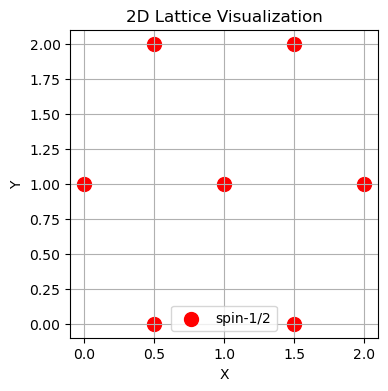

In [132]:
site_map = {
    (0, 1): "spin-1/2",
    (0.5, 0): "spin-1/2",
    (0.5, 2): "spin-1/2",
    (1, 1): "spin-1/2",
    (1.5, 0): "spin-1/2",
    (1.5, 2): "spin-1/2",
    (2, 1): "spin-1/2"
}

lattice = twodimensionalLattice(site_map)

print(lattice)
lattice.plot_lattice()

In [126]:
Sz_ops=[LocalOperator(lattice.get_site(pos), "Sz") if lattice.get_site(pos).spin_type==0.5
        else LocalOperator(lattice.get_site(pos), "Jz")
        for pos in list(site_map.keys())]

Sz_ops

[LocalOperator((0, 1), 'Sz'),
 LocalOperator((0.5, 0), 'Sz'),
 LocalOperator((0.5, 2), 'Sz'),
 LocalOperator((1, 1), 'Sz'),
 LocalOperator((1.5, 0), 'Sz'),
 LocalOperator((1.5, 2), 'Sz'),
 LocalOperator((2, 1), 'Sz')]

In [127]:

Product_Sz_ops = []
for pos in site_map.keys():
    site = lattice.get_site(pos)
    op_type = "Sz" if site.spin_type == 0.5 else "Jz"
    Product_Sz_ops.append(
        ProductOperator({site: LocalOperator(site, op_type)})
    )

Product_Sz_ops

[(0, 1):Sz,
 (0.5, 0):Sz,
 (0.5, 2):Sz,
 (1, 1):Sz,
 (1.5, 0):Sz,
 (1.5, 2):Sz,
 (2, 1):Sz]

In [128]:

Mz = SumOperator(Product_Sz_ops)
print(Mz)
Mz.tensorized_to_qobj(lattice.sites.values())


1.0 * ((0, 1):Sz) + 1.0 * ((0.5, 0):Sz) + 1.0 * ((0.5, 2):Sz) + 1.0 * ((1, 1):Sz) + 1.0 * ((1.5, 0):Sz) + 1.0 * ((1.5, 2):Sz) + 1.0 * ((2, 1):Sz)


Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]], shape = (128, 128), type = oper, isherm = True
Qobj data =
[[ 7.  0.  0. ...  0.  0.  0.]
 [ 0.  5.  0. ...  0.  0.  0.]
 [ 0.  0.  5. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -5.  0.  0.]
 [ 0.  0.  0. ...  0. -5.  0.]
 [ 0.  0.  0. ...  0.  0. -7.]]

In [80]:
site_map.keys()

dict_keys([(0, 1), (0.5, 0), (0.5, 2), (1, 1), (1.5, 0), (1.5, 2), (2, 1)])

In [73]:
list(site_map.keys())

[(0, 1), (0.5, 0), (0.5, 2), (1, 1), (1.5, 0), (1.5, 2), (2, 1)]

In [114]:
Sz_ops=[LocalOperator(lattice.get_site(pos), "Sz") if lattice.get_site(pos).spin_type==0.5
        else LocalOperator(lattice.get_site(pos), "Jz")
        for pos in list(site_map.keys())]

Product_Sz_ops = []
for pos in site_map.keys():
    site = lattice.get_site(pos)
    op_type = "Sz" if site.spin_type == 0.5 else "Jz"
    Product_Sz_ops.append(
        ProductOperator({site: LocalOperator(site, op_type)})
    )


In [118]:
Mz = SumOperator(Product_Sz_ops)
Mz.tensorized_to_qobj(lattice.sites)


AttributeError: 'tuple' object has no attribute 'get_operator'

In [117]:
site_map

{(0, 1): 'spin-1/2',
 (0.5, 0): 'spin-1/2',
 (0.5, 2): 'spin-1/2',
 (1, 1): 'spin-1/2',
 (1.5, 0): 'spin-1/2',
 (1.5, 2): 'spin-1/2',
 (2, 1): 'spin-1/2'}

In [102]:
Product_Sz_ops[0].to_qobj

AttributeError: 'ProductOperator' object has no attribute 'to_qobj'

In [93]:
list(site_map.keys()).index((0.5,2))

2

In [88]:
Product_Sz_ops

AttributeError: 'str' object has no attribute 'op_type'

In [ ]:

                if lattice.get_site(pos).spin_type==0.5
                else ProductOperator({SpinOneSite(lattice.get_site(pos)): "Jz"}

In [79]:
Sz_ops

[LocalOperator((0, 1), 'Sz'),
 LocalOperator((0.5, 0), 'Sz'),
 LocalOperator((0.5, 2), 'Sz'),
 LocalOperator((1, 1), 'Sz'),
 LocalOperator((1.5, 0), 'Sz'),
 LocalOperator((1.5, 2), 'Sz'),
 LocalOperator((2, 1), 'Sz')]

In [77]:
lattice.get_site((0,1))

SpinHalfSite(position=(0, 1), spin=0.5)

In [65]:
Iz = SumOperator([
                    ProductOperator(LocalOperator(sitei, "Sz"))
    for sitei in lattice.get_site()
                 ])

AttributeError: 'tuple' object has no attribute 'spin_type'

In [66]:
sum(lattice.get_site(pos).get_operator("Sz") for pos in site_map.keys())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 7.  0.]
 [ 0. -7.]]

In [45]:
lattice.get_site((0.5,0)).get_operator("Sz")

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [49]:
[site for site in site_map.keys()]

[(0, 1), (0.5, 0), (0.5, 2), (1, 1), (1.5, 0), (1.5, 2), (2, 1)]

In [53]:
lattice.get_site((0.5,0)).spin_type

0.5

In [19]:
sites = [SpinHalfSite((i,j)) for i in range(1) for j in range(2)]

site00=sites[0]
site01=sites[1]

In [24]:
op1 = LocalOperator(site00, "Sx")
op2 = LocalOperator(site01, "Sz")

P1 = ProductOperator({site00: op1})
P2 = ProductOperator({site01: op2})

P12=P1*P1
P12.tensorized_to_qobj(sites)


TypeError: LocalOperator.__init__() takes 3 positional arguments but 4 were given

In [28]:
P1*P1

TypeError: LocalOperator.__init__() takes 3 positional arguments but 4 were given

In [111]:
op1.tensorized_to_qobj(sites)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

In [112]:
(H-H).tensorized_to_qobj(sites)

AttributeError: 'SumOperator' object has no attribute 'tensorized_to_qobj'

In [113]:
(op1-op1).tensorized_to_qobj(sites)

AttributeError: 'SumOperator' object has no attribute 'tensorized_to_qobj'

In [114]:
H.tensorized_to_qobj(sites)-H.tensorized_to_qobj(sites)

AttributeError: 'SumOperator' object has no attribute 'tensorized_to_qobj'

In [91]:
(H-H).tensorized_to_qobj(sites)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  3.  0.]
 [ 0.  0.  0. -1.]
 [ 3.  0.  0.  0.]
 [ 0. -1.  0.  0.]]

In [41]:
lattice.get_neighbors((1,1), distance=1.5)

[(0, 1), (0.5, 0), (0.5, 2)]

In [42]:
def decompose_operator_to_terms(operator, lattice):
    """
    Decompose an arbitrary operator into sums of tensor products of smaller qutip Qobjs.
    
    operator: A qutip.Qobj representing the Hamiltonian or any operator.
    lattice: An instance of twodimensionalLattice that contains the SpinSites.
    
    Returns a list of smaller qutip.Qobjs representing the decomposition.
    """
    terms = []
    num_sites = len(lattice.sites)
    
    # We are assuming `operator` is already in the form of a qutip.Qobj.
    # The operator could be in the tensor product form already, or could be a sum of terms.
    
    # To simplify, we will first check if the operator is already a tensor product.
    if operator.dims[0] == operator.dims[1]:
        # Let's assume it's a sum of tensor products of operators.
        
        # Loop over each site and try to extract the local operators at that site
        for pos, site in lattice.sites.items():
            local_ops = site.operators  # This should be a dictionary with 'X', 'Y', 'Z' operators

            for op_name, local_op in local_ops.items():
                # Generate the tensor product operator with the local operator at each site
                local_tensor = [qutip.qeye(2) for _ in range(num_sites)]  # Identity for all sites
                local_tensor[list(lattice.sites.keys()).index(pos)] = local_op  # Replace the identity at `pos`
                
                # Construct the tensor product and add it to terms
                tensor_op = qutip.tensor(local_tensor)
                terms.append(tensor_op)
    else:
        # The operator isn't directly in tensor form; we may need to handle a sum of operators
        pass  # You can add logic to handle non-tensorized operators
    
    return terms

In [50]:
K0 = qutip.tensor(qutip.sigmax(), qutip.sigmaz(), qutip.sigmaz(), qutip.sigmax())
K0terms= decompose_operator_to_terms(K0, lattice)

In [51]:
len(K0terms)

16

In [34]:
K0terms[0]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]

In [35]:
K0

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]]

In [52]:
dim_list

[1, 0.5, 1]

In [42]:
target_site.get_operator("Jx")

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.70710678]
 [0.         0.70710678 0.        ]]

In [13]:
lattice.get_site((0,0))

SpinOneSite(position=(0, 0), spin=1)

In [7]:
lattice.get_local_spin_ops((1,1))

{'Sx': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 1.]
  [1. 0.]],
 'Sy': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 'Sz': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]],
 'id2': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[1. 0.]
  [0. 1.]]}

In [30]:
lattice

In [31]:
site_map

{(0, 0): 'spin-1'}

In [33]:
list(site_map.keys())

[(0, 0)]

In [2]:

class LatticeOperators:
    def __init__(self, Lx, Ly):
        """
        Initialize a 2D lattice of size Lx x Ly, storing operators at each site.
        """
        self.Lx = Lx
        self.Ly = Ly
        self.operators = {}  # Dictionary to store operators per site
        self._initialize_operators()
    
    de
    
    def _initialize_operators(self):
        """
        Initialize the dictionary to store Pauli matrices at each lattice site.
        """
        Sz = qutip.sigmaz()
        Sx = qutip.sigmax()        
        Sy = qutip.sigmay()
        
        for i in range(self.Lx):
            for j in range(self.Ly):
                self.operators[(i, j)] = {"Sz": Sz, "Sx": Sx, "Sy": Sy}
    
    def get_operator(self, site, op_type):
        """
        Retrieve an operator of type op_type ("Sz", "Sx", "Sy") at a given site (i, j).
        """
        return self.operators.get(site, {}).get(op_type, None)
    
    def get_neighbors(self, site):
        """
        Get nearest neighbors of a given site in a 2D lattice.
        """
        i, j = site
        neighbors = []
        if i > 0: neighbors.append((i-1, j))  # Left
        if i < self.Lx-1: neighbors.append((i+1, j))  # Right
        if j > 0: neighbors.append((i, j-1))  # Down
        if j < self.Ly-1: neighbors.append((i, j+1))  # Up
        return neighbors
    
    def apply_two_site_operator(self, site1, site2, op1, op2):
        """
        Compute the tensor product of two operators acting on different sites.
        """
        Op1 = self.get_operator(site1, op1)
        Op2 = self.get_operator(site2, op2)
        if Op1 is not None and Op2 is not None:
            return qutip.tensor(Op1, Op2)
        else:
            raise ValueError("Invalid site or operator type.")

# Example usage:
L = LatticeOperators(3, 3)
site = (1, 1)
print("Operators at site", site, ":", L.operators[site])
print("Neighbors of site (1,1):", L.get_neighbors((1,1)))
print("Sz at (1,1) ⊗ Sx at (1,2):\n", L.apply_two_site_operator((1,1), (1,2), "Sz", "Sx"))


NameError: name 'de' is not defined

In [19]:

L = LatticeOperators(6, 6)
site=(1,1)
L.operators[site]
L.get_neighbors(site)
L.apply_two_site_operator(site,L.get_neighbors(site)[3], "Sx", "Sx")

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]